In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

raw_dataset = pd.read_csv("/data/fast0/datasets/glathida-3.1.0/data/T.csv")
# raw_dataset = pd.read_csv("~/notebooks/glac/data/TTT.csv")
# raw_dataset = pd.read_csv("~/stuff/coding/glacier/glac/data/T.csv")

dataset = raw_dataset.copy()

#examine missing data
# dataset.head()

2.5.0


In [2]:
#drop everything but lat, long, elevation, thickness

dataset = dataset.drop("GlaThiDa_ID", axis=1)
dataset = dataset.drop("GLACIER_DB", axis=1)
dataset = dataset.drop("POLITICAL_UNIT", axis=1)
dataset = dataset.drop("GLACIER_ID", axis=1)
dataset = dataset.drop("GLACIER_NAME", axis=1)
dataset = dataset.drop("SURVEY_DATE", axis=1)
dataset = dataset.drop("MEAN_THICKNESS_UNCERTAINTY", axis=1)
dataset = dataset.drop("MAXIMUM_THICKNESS", axis=1)
dataset = dataset.drop("MAX_THICKNESS_UNCERTAINTY", axis=1)
dataset = dataset.drop("DATA_FLAG", axis=1)
dataset = dataset.drop("ELEVATION_DATE", axis=1)
dataset = dataset.drop("SPONSORING_AGENCY", axis=1)
dataset = dataset.drop("REMARKS", axis=1)
dataset = dataset.drop("SURVEY_METHOD_DETAILS", axis=1)
dataset = dataset.drop("SURVEY_METHOD", axis=1)
dataset = dataset.drop("NUMBER_OF_SURVEY_POINTS", axis=1)
dataset = dataset.drop("NUMBER_OF_SURVEY_PROFILES", axis=1)
dataset = dataset.drop("TOTAL_LENGTH_OF_SURVEY_PROFILES", axis=1)
dataset = dataset.drop("INTERPOLATION_METHOD", axis=1)
dataset = dataset.drop("INVESTIGATOR", axis=1)
dataset = dataset.drop("REFERENCES", axis=1)

#sum up rows with empty cells
dataset.isna().sum()

#drop the remaining null pieces from elevation
dataset = dataset.dropna()
dataset.isna().sum()

LAT               0
LON               0
AREA              0
MEAN_SLOPE        0
MEAN_THICKNESS    0
dtype: int64

In [38]:
dataset

,LAT,LON,AREA,MEAN_SLOPE,MEAN_THICKNESS
32,48.750000,-121.830000,2.900,0.0,58.0
33,58.380000,-134.360000,11.700,0.0,66.0
34,50.061340,87.697410,5.150,0.0,56.0
35,50.049670,87.745520,2.840,0.0,86.0
36,50.080080,87.690250,5.950,0.0,90.0
...,...,...,...,...,...
620,78.245480,16.064380,2.100,13.0,32.0
628,43.043653,77.080587,2.610,20.0,47.0
632,77.971400,14.069100,6.737,6.0,65.0
749,77.027200,15.485400,0.370,19.0,27.0


# 

In [3]:
#split the dataset and reserve some to test what was trained.
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

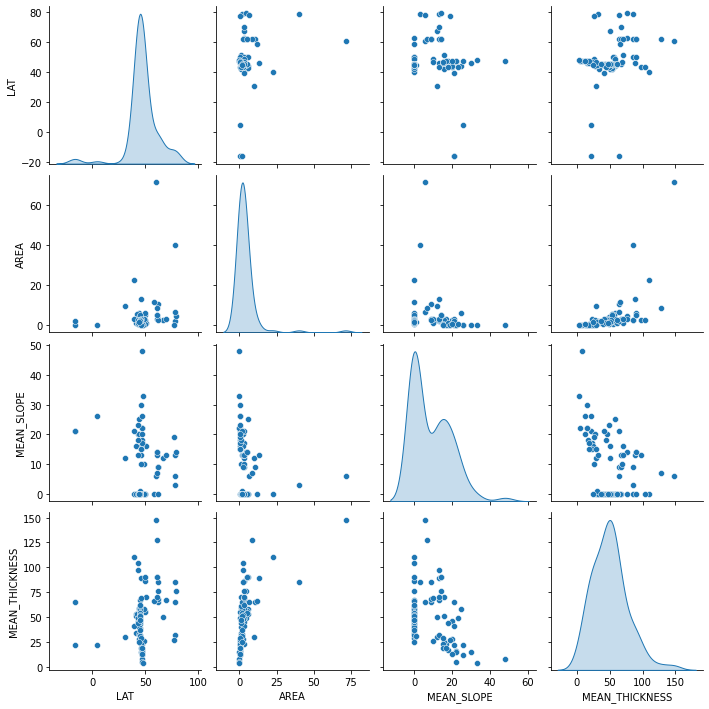

In [5]:
sns.pairplot(train_dataset[["LAT", "AREA", "MEAN_SLOPE", "MEAN_THICKNESS"]], diag_kind='kde')

In [40]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
LAT,89.0,47.465341,14.458029,-16.3023,44.584600,45.080000,48.75000,78.87100
LON,89.0,41.704321,55.546192,-134.3600,8.602228,78.176022,79.82588,140.86536
AREA,89.0,4.060882,8.853776,0.0264,1.000000,2.100000,3.22750,71.30000
MEAN_SLOPE,89.0,8.797753,10.230502,0.0000,0.000000,6.000000,16.00000,48.00000
MEAN_THICKNESS,89.0,50.460674,27.011806,4.0000,30.000000,49.000000,65.00000,148.00000


In [5]:
#separate out features - what will be trained to predict desired attribute
train_features = train_dataset.copy()
test_features = test_dataset.copy()

#define label - attribute training to be picked
train_labels = train_features.pop("MEAN_THICKNESS")
test_labels = test_features.pop("MEAN_THICKNESS")

train_features.describe().transpose()[['mean', 'std']]

,mean,std
LAT,47.465341,14.458029
LON,41.704321,55.546192
AREA,4.060882,8.853776
MEAN_SLOPE,8.797753,10.230502


# Establish normalization layers

In [6]:
#build normalizer layers for each model to be run

normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

area = np.array(train_features["AREA"])
area_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
area_normalizer.adapt(area)

lat = np.array(train_features["LAT"])
lat_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
lat_normalizer.adapt(lat)

lon = np.array(train_features["LON"])
lon_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
lon_normalizer.adapt(lon)

slope = np.array(train_features["MEAN_SLOPE"])
slope_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
slope_normalizer.adapt(slope)

# build model function to call

In [9]:
# #how to condense model into callable function with fillable variables? even possible?
# 88_model = tf.keras.Sequential([
#     88_normalizer,
#     layers.Dense(1)
# ])


# 88_model.compile(
#     optimizer=tf.optimizers.Adam(learning_rate=0.1),
#     loss="mean_absolute_error")

# %%time
# history_88 = 88_model.fit(
#     train_features["*^*"], train_labels,
#     epochs=400,
#     # suppress logging
#     verbose=0,
#     # Calculate validation results on 20% of the training data
#     validation_split = 0.2)

# test_results = {}
# test_results["*_model"] = area_model.evaluate(
#     test_features["*^*"],
#     test_labels, verbose=0)

# test_results

# def plot_area(x, y):
#     plt.scatter(train_features["*^*"], train_labels, label='Data')
#     plt.plot(x, y, color='k', label='Predictions')
#     plt.xlabel('Area (km**2)')
#     plt.ylabel('Thickness')
#     plt.xlim((0,20))
#     plt.legend()
    
# x = tf.linspace(0.0, 20, 101)
# y = area_model.predict(x)
# plot_area(x,y)

# def plot_loss(history_area):
#   plt.plot(history_area.history['loss'], label='loss')
#   plt.plot(history_area.history['val_loss'], label='val_loss')
# #   plt.ylim([0, 10])
#   plt.xlabel('Epoch')
#   plt.ylabel('Error [MPG]')
#   plt.legend()
#   plt.grid(True)
# plot_loss(history_area)



# Linear regression with area

In [10]:
#build elevation model with Sequential
area_model = tf.keras.Sequential([
    area_normalizer,
    layers.Dense(1)
])

area_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.6),
    loss="mean_absolute_error")

history_area = area_model.fit(
    train_features["AREA"], train_labels,
    epochs=1000,
    verbose=0,
    validation_split = 0.2)

test_results = {}
test_results['area_model'] = area_model.evaluate(
    test_features['AREA'],
    test_labels, verbose=0)

test_results

{'area_model': 74.47103881835938}

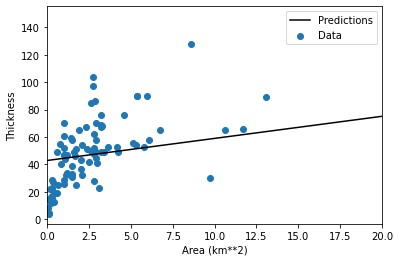

In [11]:
def plot_area(x, y):
    plt.scatter(train_features['AREA'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Area (km**2)')
    plt.ylabel('Thickness')
    plt.xlim((0,20))
    plt.legend()
    
x = tf.linspace(0.0, 20, 101)
y = area_model.predict(x)
plot_area(x,y)

In [21]:
def plot_loss(history_area):
    plt.subplots(figsize=(10,5))
    plt.plot(history_area.history['loss'], label='loss')
    plt.plot(history_area.history['val_loss'], label='val_loss')
    #   plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [Area, km**2]')
    plt.legend()
    plt.grid(True)



In [ ]:
plot_loss(history_area)

# Linear regression with latitude

In [13]:
#build elevation model with Sequential
lat_model = tf.keras.Sequential([
    lat_normalizer,
    layers.Dense(1)
])

lat_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss="mean_absolute_error")

history_lat = lat_model.fit(
    train_features["LAT"], train_labels,
    epochs=400,
    verbose=0,
    validation_split = 0.2)

test_results["lat_model"] = area_model.evaluate(
    test_features["LAT"],
    test_labels, verbose=0)

test_results

{'area_model': 74.47103881835938, 'lat_model': 81.59545135498047}

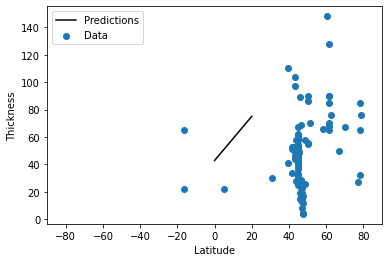

In [14]:
def plot_latitude(x, y):
    plt.scatter(train_features["LAT"], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel("Latitude")
    plt.ylabel('Thickness')
    plt.xlim((-90,90))
    plt.legend()
    
x = tf.linspace(0.0, 20, 101)
y = area_model.predict(x)
plot_latitude(x,y)

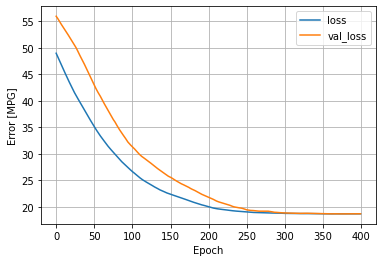

In [15]:
plot_loss(history_lat)

# Linear regression with longitude

In [16]:
lon_model = tf.keras.Sequential([
    lon_normalizer,
    layers.Dense(1)
])

lon_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss="mean_absolute_error")

history_lon = lon_model.fit(
    train_features["LON"], train_labels,
    epochs=400,
    verbose=0,
    validation_split = 0.2)

test_results["lon_model"] = area_model.evaluate(
    test_features["LON"],
    test_labels, verbose=0)

test_results

{'area_model': 74.47103881835938,
 'lat_model': 81.59545135498047,
 'lon_model': 92.00907135009766}

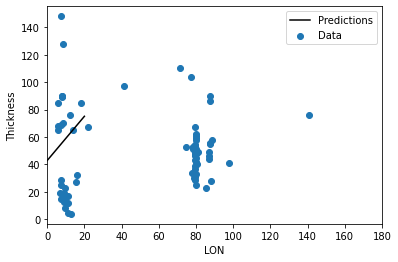

In [17]:
def plot_longitude(x, y):
    plt.scatter(train_features["LON"], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('LON')
    plt.ylabel('Thickness')
    plt.xlim((0,180))
    plt.legend()
    
x = tf.linspace(0.0, 20, 101)
y = area_model.predict(x)
plot_longitude(x,y)

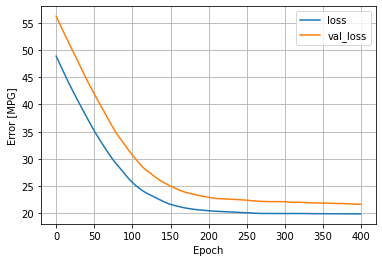

In [18]:
plot_loss(history_lon)

# Multiple inputs

In [19]:
normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
multi_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [20]:
multi_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    loss='mean_absolute_error')

In [21]:
%%time
history_multi = multi_model.fit(
    train_features, train_labels, 
    epochs=1000,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 12.5 s, sys: 613 ms, total: 13.1 s
Wall time: 11.3 s


In [22]:
#not sure what exactly is going on here but I'm sure this is what needs tweaking
test_results["multi_model"] = multi_model.evaluate(
    test_features,
    test_labels, verbose=0)

test_results

{'area_model': 74.47103881835938,
 'lat_model': 81.59545135498047,
 'lon_model': 92.00907135009766,
 'multi_model': 47.73617935180664}

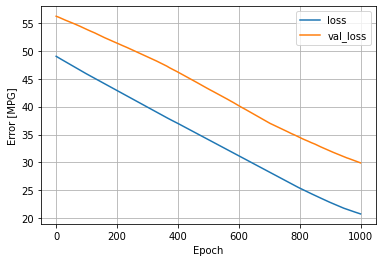

In [23]:
plot_loss(history_multi)

# DNN regression

### Single variable

In [17]:
def build_and_compile_model(norm):
    model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.01))
    return model

In [46]:
dnn_area_model = build_and_compile_model(area_normalizer)

In [47]:
dnn_area_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                128       
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [27]:
%%time
history_dnn = dnn_area_model.fit(
    train_features["AREA"], train_labels,
    validation_split=0.2,
    #verbose=0,
    epochs=1500)

Epoch 1/1500
3/3 [==============================] - 0s 35ms/step - loss: 48.8946 - val_loss: 56.4539
Epoch 2/1500
3/3 [==============================] - 0s 6ms/step - loss: 48.8884 - val_loss: 56.4494
Epoch 3/1500
3/3 [==============================] - 0s 6ms/step - loss: 48.8833 - val_loss: 56.4451
Epoch 4/1500
3/3 [==============================] - 0s 6ms/step - loss: 48.8776 - val_loss: 56.4408
Epoch 5/1500
3/3 [==============================] - 0s 6ms/step - loss: 48.8723 - val_loss: 56.4366
Epoch 6/1500
3/3 [==============================] - 0s 6ms/step - loss: 48.8673 - val_loss: 56.4324
Epoch 7/1500
3/3 [==============================] - 0s 6ms/step - loss: 48.8619 - val_loss: 56.4282
Epoch 8/1500
3/3 [==============================] - 0s 6ms/step - loss: 48.8566 - val_loss: 56.4240
Epoch 9/1500
3/3 [==============================] - 0s 6ms/step - loss: 48.8511 - val_loss: 56.4197
Epoch 10/1500
3/3 [==============================] - 0s 6ms/step - loss: 48.8458 - val_loss: 56.415

3/3 [==============================] - 0s 6ms/step - loss: 45.9060 - val_loss: 53.8021
Epoch 163/1500
3/3 [==============================] - 0s 6ms/step - loss: 45.8640 - val_loss: 53.7630
Epoch 164/1500
3/3 [==============================] - 0s 6ms/step - loss: 45.8209 - val_loss: 53.7234
Epoch 165/1500
3/3 [==============================] - 0s 6ms/step - loss: 45.7775 - val_loss: 53.6834
Epoch 166/1500
3/3 [==============================] - 0s 6ms/step - loss: 45.7332 - val_loss: 53.6428
Epoch 167/1500
3/3 [==============================] - 0s 6ms/step - loss: 45.6894 - val_loss: 53.6017
Epoch 168/1500
3/3 [==============================] - 0s 6ms/step - loss: 45.6443 - val_loss: 53.5606
Epoch 169/1500
3/3 [==============================] - 0s 7ms/step - loss: 45.5974 - val_loss: 53.5190
Epoch 170/1500
3/3 [==============================] - 0s 6ms/step - loss: 45.5521 - val_loss: 53.4766
Epoch 171/1500
3/3 [==============================] - 0s 6ms/step - loss: 45.5047 - val_loss: 53.

3/3 [==============================] - 0s 6ms/step - loss: 34.3087 - val_loss: 42.1796
Epoch 323/1500
3/3 [==============================] - 0s 6ms/step - loss: 34.2133 - val_loss: 42.0799
Epoch 324/1500
3/3 [==============================] - 0s 6ms/step - loss: 34.1179 - val_loss: 41.9803
Epoch 325/1500
3/3 [==============================] - 0s 6ms/step - loss: 34.0224 - val_loss: 41.8811
Epoch 326/1500
3/3 [==============================] - 0s 6ms/step - loss: 33.9296 - val_loss: 41.7825
Epoch 327/1500
3/3 [==============================] - 0s 6ms/step - loss: 33.8403 - val_loss: 41.6830
Epoch 328/1500
3/3 [==============================] - 0s 6ms/step - loss: 33.7492 - val_loss: 41.5846
Epoch 329/1500
3/3 [==============================] - 0s 6ms/step - loss: 33.6610 - val_loss: 41.4872
Epoch 330/1500
3/3 [==============================] - 0s 6ms/step - loss: 33.5676 - val_loss: 41.3923
Epoch 331/1500
3/3 [==============================] - 0s 6ms/step - loss: 33.4801 - val_loss: 41.

3/3 [==============================] - 0s 6ms/step - loss: 21.8273 - val_loss: 28.3236
Epoch 483/1500
3/3 [==============================] - 0s 6ms/step - loss: 21.7798 - val_loss: 28.2620
Epoch 484/1500
3/3 [==============================] - 0s 6ms/step - loss: 21.7226 - val_loss: 28.1990
Epoch 485/1500
3/3 [==============================] - 0s 6ms/step - loss: 21.6740 - val_loss: 28.1364
Epoch 486/1500
3/3 [==============================] - 0s 6ms/step - loss: 21.6145 - val_loss: 28.0770
Epoch 487/1500
3/3 [==============================] - 0s 6ms/step - loss: 21.5654 - val_loss: 28.0215
Epoch 488/1500
3/3 [==============================] - 0s 6ms/step - loss: 21.5041 - val_loss: 27.9691
Epoch 489/1500
3/3 [==============================] - 0s 6ms/step - loss: 21.4608 - val_loss: 27.9096
Epoch 490/1500
3/3 [==============================] - 0s 6ms/step - loss: 21.4074 - val_loss: 27.8509
Epoch 491/1500
3/3 [==============================] - 0s 6ms/step - loss: 21.3537 - val_loss: 27.

3/3 [==============================] - 0s 6ms/step - loss: 19.1482 - val_loss: 23.2179
Epoch 643/1500
3/3 [==============================] - 0s 6ms/step - loss: 19.1426 - val_loss: 23.2057
Epoch 644/1500
3/3 [==============================] - 0s 6ms/step - loss: 19.1381 - val_loss: 23.1942
Epoch 645/1500
3/3 [==============================] - 0s 6ms/step - loss: 19.1303 - val_loss: 23.1831
Epoch 646/1500
3/3 [==============================] - 0s 6ms/step - loss: 19.1240 - val_loss: 23.1727
Epoch 647/1500
3/3 [==============================] - 0s 6ms/step - loss: 19.1185 - val_loss: 23.1637
Epoch 648/1500
3/3 [==============================] - 0s 6ms/step - loss: 19.1127 - val_loss: 23.1569
Epoch 649/1500
3/3 [==============================] - 0s 6ms/step - loss: 19.1078 - val_loss: 23.1476
Epoch 650/1500
3/3 [==============================] - 0s 6ms/step - loss: 19.1004 - val_loss: 23.1358
Epoch 651/1500
3/3 [==============================] - 0s 6ms/step - loss: 19.0954 - val_loss: 23.

3/3 [==============================] - 0s 7ms/step - loss: 18.1753 - val_loss: 21.1932
Epoch 803/1500
3/3 [==============================] - 0s 6ms/step - loss: 18.1678 - val_loss: 21.1835
Epoch 804/1500
3/3 [==============================] - 0s 6ms/step - loss: 18.1630 - val_loss: 21.1675
Epoch 805/1500
3/3 [==============================] - 0s 6ms/step - loss: 18.1564 - val_loss: 21.1581
Epoch 806/1500
3/3 [==============================] - 0s 6ms/step - loss: 18.1527 - val_loss: 21.1486
Epoch 807/1500
3/3 [==============================] - 0s 6ms/step - loss: 18.1478 - val_loss: 21.1413
Epoch 808/1500
3/3 [==============================] - 0s 7ms/step - loss: 18.1418 - val_loss: 21.1376
Epoch 809/1500
3/3 [==============================] - 0s 7ms/step - loss: 18.1367 - val_loss: 21.1312
Epoch 810/1500
3/3 [==============================] - 0s 6ms/step - loss: 18.1320 - val_loss: 21.1256
Epoch 811/1500
3/3 [==============================] - 0s 6ms/step - loss: 18.1267 - val_loss: 21.

3/3 [==============================] - 0s 6ms/step - loss: 17.4248 - val_loss: 20.2624
Epoch 963/1500
3/3 [==============================] - 0s 6ms/step - loss: 17.4242 - val_loss: 20.2378
Epoch 964/1500
3/3 [==============================] - 0s 6ms/step - loss: 17.4187 - val_loss: 20.2195
Epoch 965/1500
3/3 [==============================] - 0s 6ms/step - loss: 17.4143 - val_loss: 20.2049
Epoch 966/1500
3/3 [==============================] - 0s 6ms/step - loss: 17.4112 - val_loss: 20.1907
Epoch 967/1500
3/3 [==============================] - 0s 7ms/step - loss: 17.4094 - val_loss: 20.1792
Epoch 968/1500
3/3 [==============================] - 0s 6ms/step - loss: 17.4056 - val_loss: 20.1713
Epoch 969/1500
3/3 [==============================] - 0s 6ms/step - loss: 17.4040 - val_loss: 20.1640
Epoch 970/1500
3/3 [==============================] - 0s 6ms/step - loss: 17.3990 - val_loss: 20.1633
Epoch 971/1500
3/3 [==============================] - 0s 6ms/step - loss: 17.3949 - val_loss: 20.

3/3 [==============================] - 0s 6ms/step - loss: 17.1473 - val_loss: 19.8820
Epoch 1043/1500
3/3 [==============================] - 0s 6ms/step - loss: 17.1442 - val_loss: 19.8819
Epoch 1044/1500
3/3 [==============================] - 0s 6ms/step - loss: 17.1400 - val_loss: 19.8767
Epoch 1045/1500
3/3 [==============================] - 0s 6ms/step - loss: 17.1372 - val_loss: 19.8718
Epoch 1046/1500
3/3 [==============================] - 0s 6ms/step - loss: 17.1343 - val_loss: 19.8644
Epoch 1047/1500
3/3 [==============================] - 0s 6ms/step - loss: 17.1318 - val_loss: 19.8608
Epoch 1048/1500
3/3 [==============================] - 0s 6ms/step - loss: 17.1290 - val_loss: 19.8577
Epoch 1049/1500
3/3 [==============================] - 0s 6ms/step - loss: 17.1252 - val_loss: 19.8602
Epoch 1050/1500
3/3 [==============================] - 0s 6ms/step - loss: 17.1217 - val_loss: 19.8708
Epoch 1051/1500
3/3 [==============================] - 0s 6ms/step - loss: 17.1180 - val_

3/3 [==============================] - 0s 6ms/step - loss: 16.7280 - val_loss: 19.5452
Epoch 1201/1500
3/3 [==============================] - 0s 6ms/step - loss: 16.7237 - val_loss: 19.5530
Epoch 1202/1500
3/3 [==============================] - 0s 6ms/step - loss: 16.7222 - val_loss: 19.5543
Epoch 1203/1500
3/3 [==============================] - 0s 6ms/step - loss: 16.7190 - val_loss: 19.5480
Epoch 1204/1500
3/3 [==============================] - 0s 6ms/step - loss: 16.7189 - val_loss: 19.5382
Epoch 1205/1500
3/3 [==============================] - 0s 6ms/step - loss: 16.7146 - val_loss: 19.5360
Epoch 1206/1500
3/3 [==============================] - 0s 6ms/step - loss: 16.7127 - val_loss: 19.5309
Epoch 1207/1500
3/3 [==============================] - 0s 6ms/step - loss: 16.7103 - val_loss: 19.5240
Epoch 1208/1500
3/3 [==============================] - 0s 6ms/step - loss: 16.7083 - val_loss: 19.5212
Epoch 1209/1500
3/3 [==============================] - 0s 6ms/step - loss: 16.7061 - val_

3/3 [==============================] - 0s 6ms/step - loss: 16.4551 - val_loss: 19.2945
Epoch 1359/1500
3/3 [==============================] - 0s 6ms/step - loss: 16.4538 - val_loss: 19.2985
Epoch 1360/1500
3/3 [==============================] - 0s 6ms/step - loss: 16.4518 - val_loss: 19.3048
Epoch 1361/1500
3/3 [==============================] - 0s 6ms/step - loss: 16.4491 - val_loss: 19.3168
Epoch 1362/1500
3/3 [==============================] - 0s 6ms/step - loss: 16.4461 - val_loss: 19.3326
Epoch 1363/1500
3/3 [==============================] - 0s 6ms/step - loss: 16.4458 - val_loss: 19.3429
Epoch 1364/1500
3/3 [==============================] - 0s 6ms/step - loss: 16.4423 - val_loss: 19.3474
Epoch 1365/1500
3/3 [==============================] - 0s 6ms/step - loss: 16.4405 - val_loss: 19.3558
Epoch 1366/1500
3/3 [==============================] - 0s 6ms/step - loss: 16.4395 - val_loss: 19.3682
Epoch 1367/1500
3/3 [==============================] - 0s 6ms/step - loss: 16.4392 - val_

In [30]:
dnn_test_results = {}
dnn_test_results['dnn_area_model'] = dnn_area_model.evaluate(
    test_features["AREA"], test_labels,
    verbose=0)

# Full model (not-quite-working)

In [18]:
normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
dnn_full_model = build_and_compile_model(normalizer)
dnn_full_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_7 (Normalizati (None, 4)                 9         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                320       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,554
Trainable params: 4,545
Non-trainable params: 9
_________________________________________________________________


In [31]:
%%time
history_full = dnn_full_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 3.08 s, sys: 1.06 s, total: 4.14 s
Wall time: 1.34 s


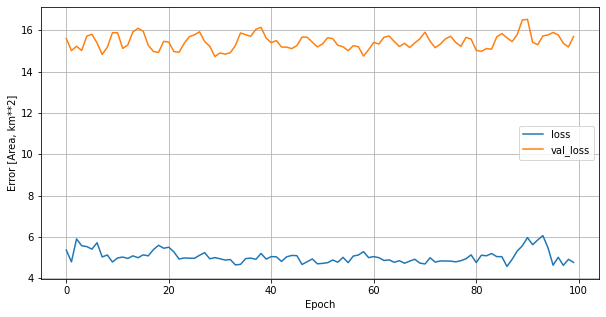

In [32]:
plot_loss(history_full)

Text(0, 0.5, 'Model Area (km**2)')

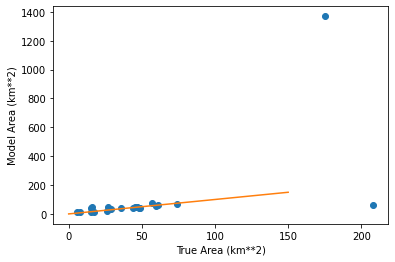

In [88]:
y = dnn_full_model.predict(test_features)
plt.plot(test_labels,y,'o')
plt.plot((0,150),(0,150),'-')
plt.xlabel('True Area (km**2)')
plt.ylabel('Model Area (km**2)')

Text(0, 0.5, 'Count')

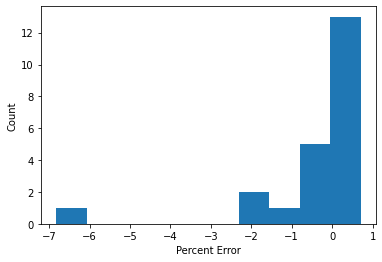

In [89]:
plt.subplots()
x = np.reshape(test_labels.values, (-1, 1)) # Training values in a n-by-1 array
pct_error = (x-y)/x
plt.hist(pct_error.flatten())
plt.xlabel('Percent Error')
plt.ylabel('Count')

In [33]:
test_results["dnn_full_model"] = dnn_full_model.evaluate(
    test_features,
    test_labels, verbose=0)

test_results

NameError: name 'test_results' is not defined